In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
#!pip install mlflow
import mlflow
import mlflow.sklearn

In [28]:
model_data = pd.read_csv('model_data2_2021_2022.csv')

In [29]:
model_data.columns

Index(['cv_cc', 'cv2_cc', 'cv2_act', 'sex', 'stroke', 'cv2_cphss', 'triage',
       'onset', 'age', 'dbp1', 'sbp1', 'pr1', 'rr1', 'bt1', 'spo2_1',
       'Weekday', 'Month', 'Year', 'Hour', 'Minute', 'Spasm', 'Dizziness',
       'Faint', 'Consciousness', 'Paralysis', 'hy_di_disease',
       'Disease_counts'],
      dtype='object')

In [30]:
model_data.shape

(104457, 27)

In [33]:
#!pip install -U scikit-learn

In [31]:
## Data splitting and scaling
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, f1_score
from tqdm import tqdm

In [33]:
X = model_data.iloc[:,model_data.columns != 'cv2_cphss']
y = model_data.cv2_cphss
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5, stratify=y)

In [34]:
#!pip install lazypredict
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [24:14<00:00, 50.15s/it] 


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.85,0.84,0.84,0.85,0.55
RandomForestClassifier,0.85,0.84,0.84,0.85,12.23
XGBClassifier,0.85,0.84,0.84,0.85,3.25
ExtraTreesClassifier,0.85,0.84,0.84,0.85,9.47
AdaBoostClassifier,0.85,0.84,0.84,0.84,3.48
SVC,0.85,0.83,0.83,0.84,807.10
NuSVC,0.84,0.83,0.83,0.84,516.64
LinearSVC,0.84,0.83,0.83,0.83,19.82
LinearDiscriminantAnalysis,0.84,0.83,0.83,0.83,0.54


In [9]:
#mlflow.set_tracking_uri("/home/nilesh/Downloads/stroke data/mlflow/mlruns")

In [10]:
#tracking_uri = mlflow.get_tracking_uri()
#tracking_uri

In [35]:
experiment_id = mlflow.create_experiment("training experiment RF")

In [36]:
n_estimators_range = np.arange(100, 500, 25)
max_depth_range = np.arange(5, 25, 2)
max_features_range = ["sqrt", None, "log2"]


for n_estimators in tqdm(n_estimators_range):
    for max_depth in tqdm(max_depth_range, leave=False):
        for max_features in tqdm(max_features_range, leave=False):

            with mlflow.start_run(experiment_id=experiment_id):

                model = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    max_features=max_features,
                    n_jobs=3,
                )

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                auc = roc_auc_score(y_test, y_pred)

                mlflow.log_param("n_estimators", n_estimators)
                mlflow.log_param("max_depth", max_depth)
                mlflow.log_param("max_features", max_features)

                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("recall", recall)
                mlflow.log_metric("f1", f1)
                mlflow.log_metric("auc", auc)

                mlflow.sklearn.log_model(model, "model")

  0%|          | 0/16 [00:00<?, ?it/s]

















































  6%|▋         | 1/16 [03:36<54:08, 216.58s/it]

















































 12%|█▎        | 2/16 [07:54<56:14, 241.04s/it]

















































 19%|█▉        | 3/16 [12:56<58:11, 268.56s/it]

















































 25%|██▌       | 4/16 [18:41<59:46, 298.87s/it]

















































 31%|███▏      | 5/16 [25:11<1:00:49, 331.78s/it]

















































 38%|███▊      | 6/16 [32:43<1:02:07, 372.73s/it]

















































 44%|████▍     | 7/16 [40:47<1:01:22, 409.17s/it]

















































 50%|█████     | 8/16 [49:35<59:33, 446.72s/it]  

















































 56%|█████▋    | 9/16 [59:04<56:36, 485.23s/it]

















































 62%|██████▎   | 10/16 [1:09:17

In [40]:
experiment_id = mlflow.create_experiment("training experiment LightGBM")

objective = 'binary'
boosting_type_range = ['gbdt', 'dart', 'goss']
max_depth_range = np.arange(1, 25, 1)
learning_rate_range = np.arange(0.001, 0.01, 0.001)



for boosting_type in tqdm(boosting_type_range):
    for max_depth in tqdm(max_depth_range, leave=False):
        for learning_rate in tqdm(learning_rate_range, leave=False):

            with mlflow.start_run(experiment_id=experiment_id):

                model = lgb.LGBMClassifier(
                    boosting_type=boosting_type,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                )

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                accuracy = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred)
                auc = roc_auc_score(y_test, y_pred)

                mlflow.log_param("boosting_type", boosting_type)
                mlflow.log_param("max_depth", max_depth)
                mlflow.log_param("learning_rate", learning_rate)

                mlflow.log_metric("accuracy", accuracy)
                mlflow.log_metric("precision", precision)
                mlflow.log_metric("recall", recall)
                mlflow.log_metric("f1", f1)
                mlflow.log_metric("auc", auc)

                mlflow.sklearn.log_model(model, "model")

  0%|          | 0/3 [00:00<?, ?it/s]







































































































































































































































































 33%|███▎      | 1/3 [07:24<14:49, 444.79s/it]







































































































































































































































































 67%|██████▋   | 2/3 [17:19<08:53, 533.22s/it]







































































































































































































































































100%|██████████| 3/3 [24:57<00:00, 499.22s/it]


In [41]:
from xgboost import XGBClassifier

experiment_id = mlflow.create_experiment("training experiment XGBoost")

objective = 'binary:logistic'
booster_type_range = ['gbtree', 'gblinear', 'dart']
max_depth_range = np.arange(1, 25, 1)
max_leaves = 0

for booster in tqdm(booster_type_range):
    for max_depth in tqdm(max_depth_range, leave=False):
        with mlflow.start_run(experiment_id=experiment_id):

            model = XGBClassifier(
                booster = booster,
                max_depth = max_depth,
                max_leaves=max_leaves,
                objective = objective
            )

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)

            mlflow.log_param("booster_type", booster)
            mlflow.log_param("max_depth", max_depth)

            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1", f1)
            mlflow.log_metric("auc", auc)

            mlflow.sklearn.log_model(model, "model")

 33%|███▎      | 1/3 [04:50<09:40, 290.16s/it]

[15:45:05] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:07] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:10] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:12] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:14] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:17] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:19] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:22] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:24] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:26] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:29] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:31] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:34] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:37] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:39] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:41] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:44] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:46] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:49] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:51] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:53] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:56] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:45:58] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



[15:46:00] WARNING: ../src/learner.cc:767: 
Parameters: { "max_depth", "max_leaves" } are not used.



100%|██████████| 3/3 [16:16<00:00, 325.65s/it]


In [42]:

# importing random forest classifier from ensemble module
from sklearn.ensemble import RandomForestClassifier

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 225, max_features = 'log2', max_depth = 23) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

# metrics are used to find accuracy or error
train_acc = clf.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test, y_pred))

The Accuracy for Training Set is 96.66846167653922
The Accuracy for Test Set is 85.30538004977983
              precision    recall  f1-score   support

         0.0       0.92      0.73      0.82      9363
         1.0       0.81      0.95      0.88     11529

    accuracy                           0.85     20892
   macro avg       0.87      0.84      0.85     20892
weighted avg       0.86      0.85      0.85     20892



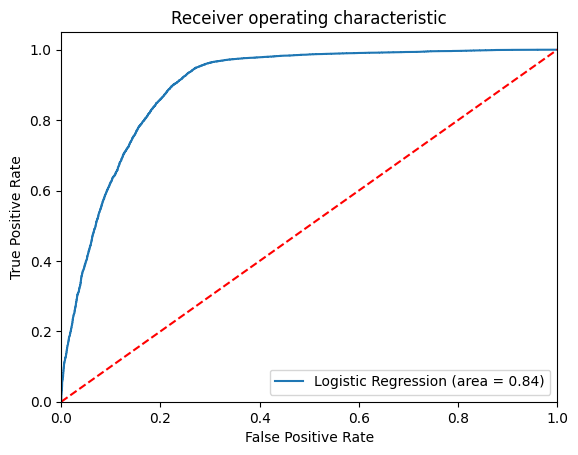

In [43]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [44]:
feature_imp = pd.Series(clf.feature_importances_, index = X_train.columns).sort_values(ascending = False)
feature_imp

cv2_cc           0.12
Faint            0.09
Dizziness        0.07
triage           0.07
cv_cc            0.07
Consciousness    0.07
Paralysis        0.07
age              0.05
cv2_act          0.04
pr1              0.04
sbp1             0.04
Minute           0.04
bt1              0.04
spo2_1           0.03
Hour             0.03
dbp1             0.03
Month            0.03
rr1              0.02
Weekday          0.02
Disease_counts   0.01
Spasm            0.01
sex              0.01
onset            0.01
stroke           0.01
hy_di_disease    0.00
Year             0.00
dtype: float64

In [47]:
model = LogisticRegression()
model.fit(X_train, y_train)
train_acc = model.score(X_train, y_train)
y_pred = model.predict(X_test)

# metrics are used to find accuracy or error
train_acc = model.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test, y_pred))

The Accuracy for Training Set is 70.0508586130557
The Accuracy for Test Set is 69.92628757419108
              precision    recall  f1-score   support

         0.0       0.68      0.62      0.65      9363
         1.0       0.71      0.77      0.74     11529

    accuracy                           0.70     20892
   macro avg       0.70      0.69      0.69     20892
weighted avg       0.70      0.70      0.70     20892



In [48]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# metrics are used to find accuracy or error
train_acc = model.score(X_train_scaled, y_train)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test, y_pred))

The Accuracy for Training Set is 83.71327708969066
The Accuracy for Test Set is 83.35247941795902
              precision    recall  f1-score   support

         0.0       0.88      0.73      0.80      9363
         1.0       0.81      0.92      0.86     11529

    accuracy                           0.83     20892
   macro avg       0.84      0.82      0.83     20892
weighted avg       0.84      0.83      0.83     20892



In [50]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 225, max_features = 'log2', max_depth = 23) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train_scaled, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test_scaled)

# metrics are used to find accuracy or error
train_acc = clf.score(X_train_scaled, y_train)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test, y_pred))

The Accuracy for Training Set is 96.63256147908812
The Accuracy for Test Set is 85.36760482481333
              precision    recall  f1-score   support

         0.0       0.93      0.73      0.82      9363
         1.0       0.81      0.95      0.88     11529

    accuracy                           0.85     20892
   macro avg       0.87      0.84      0.85     20892
weighted avg       0.86      0.85      0.85     20892

